In [79]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

matplotlib.rc("font", family="NanumGothic")
matplotlib.rc("axes", unicode_minus=False)

In [2]:
data = pd.read_csv('/home/piai/빅데이터 프로젝트/Postprocessing.csv', index_col=0)
data

,CUST_ID,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,...,LT1Y_CTLT_CNT,AUTR_FAIL_MCNT,FYCM_PAID_AMT,FMLY_CLAM_CNT,FMLY_PLPY_CNT,AGE,SEX,양육기,양육기간,TERM/MAIN
0,1,0,1,0,0,0,9001,9001,9001,0,...,0,10,0,0,0,50,1,0,6.0,0
1,2,0,1,0,0,0,24001,0,24001,0,...,0,0,300000,2,5,50,1,0,1.0,0
2,3,0,0,1,3,2,15001,9001,0,3001,...,0,0,0,0,2,60,2,0,0.0,0
3,4,1,0,2,4,2,6001,3001,0,3001,...,0,0,0,0,1,35,1,0,0.0,0
4,5,0,4,0,0,0,21001,15001,21001,0,...,0,0,500000,2,1,45,1,1,16.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100228,102248,0,1,0,2,2,75001,15001,57001,0,...,0,1,700000,0,3,55,2,0,0.0,0
100229,102249,0,2,0,0,0,54001,9001,54001,0,...,0,0,100000,0,3,45,2,1,11.0,0
100230,102250,0,1,0,0,0,27001,27001,27001,0,...,0,1,0,0,4,45,1,1,16.0,0
100231,102251,0,0,0,1,1,57001,0,0,0,...,0,0,0,0,0,45,1,0,0.0,0


In [3]:
# 양육기 전, 양육기, 양육기 후로 막내자녀나이 분류
data['양육기2'] = ''

data.loc[(data['LAST_CHLD_AGE'] == 0), "양육기2"] = "양육기 전"
data.loc[((data['LAST_CHLD_AGE'] > 0) & (data['LAST_CHLD_AGE'] <= 20)), "양육기2"] = "양육기"
data.loc[(data['LAST_CHLD_AGE'] > 20), "양육기2"] = "양육기 후"

In [4]:
#특정 열 이름
column_name = 'OCCP_NAME_G'
#해당 열 추출
occupation_column = data[column_name]
def classify_occupation(occupation):
    if occupation in ['기업/단체 임원', '고소득 전문직', '전문직']:
        return '고소득 전문직'
    elif occupation in ['단순 사무직', '사무직', '공무원']:
        return '사무직 및 관리직'
    elif occupation in ['3차산업 종사자', '자영업']:
        return '서비스 및 판매직'
    elif occupation in ['2차산업 종사자', '1차산업 종사자', '운전직', '단순노무직']:
        return '기술직 및 생산직'
    elif occupation in ['예체능계 종사자']:
        return '예체능계 종사자'
    else:
        return '학생 및 비경제 활동/기타'# 'OCCP_NAME_G' 컬럼을 바탕으로 새로운 '직업재분류' 컬럼 생성
data['직업재분류'] = data['OCCP_NAME_G'].apply(classify_occupation)# 새로운 분류를 저장할 컬럼 추가
data['직업재분류'] = occupation_column.apply(classify_occupation)# 결과 확인
print(data[['OCCP_NAME_G', '직업재분류']])

       OCCP_NAME_G           직업재분류
0              공무원       사무직 및 관리직
1              자영업       서비스 및 판매직
2               주부  학생 및 비경제 활동/기타
3               학생  학생 및 비경제 활동/기타
4              공무원       사무직 및 관리직
...            ...             ...
100228         자영업       서비스 및 판매직
100229         운전직       기술직 및 생산직
100230         자영업       서비스 및 판매직
100231         사무직       사무직 및 관리직
100232         사무직       사무직 및 관리직

[100233 rows x 2 columns]


In [5]:
data['TOTAL_LOAN_COUNT'] = data['BNK_LNIF_CNT'] + data['CPT_LNIF_CNT'] + data['SPART_LNIF_CNT'] + data['ECT_LNIF_CNT']

In [7]:
data.rename(columns={'TERM/MAIN': 'TERM_MAIN'}, inplace=True)

In [8]:
data['TERM_MAIN'].value_counts()

0    91910
1     8323
Name: TERM_MAIN, dtype: int64

In [10]:
data.corrwith(data['TERM_MAIN'])

/tmp/ipykernel_12569/4116082767.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corrwith(data['TERM_MAIN'])


CUST_ID             -0.001527
TARGET               0.028773
BNK_LNIF_CNT         0.002318
CPT_LNIF_CNT         0.006479
SPART_LNIF_CNT       0.010350
ECT_LNIF_CNT         0.007906
TOT_LNIF_AMT         0.001966
TOT_CLIF_AMT        -0.002990
BNK_LNIF_AMT         0.000559
CPT_LNIF_AMT         0.002182
CRDT_OCCR_MDIF       0.010276
SPTCT_OCCR_MDIF      0.014624
CRDT_CARD_CNT        0.000512
CTCD_OCCR_MDIF       0.008415
CB_GUIF_CNT         -0.002494
CB_GUIF_AMT         -0.002164
CUST_JOB_INCM       -0.008431
HSHD_INFR_INCM       0.018452
ACTL_FMLY_NUM        0.124044
CUST_FMLY_NUM        0.027766
LAST_CHLD_AGE        0.089887
MATE_JOB_INCM        0.070410
CRDT_LOAN_CNT        0.075056
MIN_CNTT_DATE        0.081393
TOT_CRLN_AMT         0.068693
TOT_REPY_AMT         0.059276
CRLN_OVDU_RATE       0.064324
CRLN_30OVDU_RATE     0.028535
LT1Y_CLOD_RATE       0.027370
STRT_CRDT_GRAD       0.056617
LTST_CRDT_GRAD       0.069372
PREM_OVDU_RATE       0.135888
AVG_STLN_RATE        0.098339
STLN_REMN_

In [ ]:
LT1Y_CTLT_CNT AUTR_FAIL_MCNT ACTL_FMLY_NUM PREM_OVDU_RATE GDINS_MON_PREM FMLY_GDINS_MNPREM MAX_MON_PREM

In [11]:
data.columns

Index(['CUST_ID', 'TARGET', 'BNK_LNIF_CNT', 'CPT_LNIF_CNT', 'SPART_LNIF_CNT',
       'ECT_LNIF_CNT', 'TOT_LNIF_AMT', 'TOT_CLIF_AMT', 'BNK_LNIF_AMT',
       'CPT_LNIF_AMT', 'CRDT_OCCR_MDIF', 'SPTCT_OCCR_MDIF', 'CRDT_CARD_CNT',
       'CTCD_OCCR_MDIF', 'CB_GUIF_CNT', 'CB_GUIF_AMT', 'OCCP_NAME_G',
       'CUST_JOB_INCM', 'HSHD_INFR_INCM', 'ACTL_FMLY_NUM', 'CUST_FMLY_NUM',
       'LAST_CHLD_AGE', 'MATE_OCCP_NAME_G', 'MATE_JOB_INCM', 'CRDT_LOAN_CNT',
       'MIN_CNTT_DATE', 'TOT_CRLN_AMT', 'TOT_REPY_AMT', 'CRLN_OVDU_RATE',
       'CRLN_30OVDU_RATE', 'LT1Y_CLOD_RATE', 'STRT_CRDT_GRAD',
       'LTST_CRDT_GRAD', 'PREM_OVDU_RATE', 'LT1Y_PEOD_RATE', 'AVG_STLN_RATE',
       'STLN_REMN_AMT', 'LT1Y_STLN_AMT', 'LT1Y_SLOD_RATE', 'GDINS_MON_PREM',
       'SVINS_MON_PREM', 'FMLY_GDINS_MNPREM', 'FMLY_SVINS_MNPREM',
       'MAX_MON_PREM', 'TOT_PREM', 'FMLY_TOT_PREM', 'CNTT_LAMT_CNT',
       'LT1Y_CTLT_CNT', 'AUTR_FAIL_MCNT', 'FYCM_PAID_AMT', 'FMLY_CLAM_CNT',
       'FMLY_PLPY_CNT', 'AGE', 'SEX', '양육기', '

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100233 entries, 0 to 100232
Data columns (total 60 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CUST_ID            100233 non-null  int64  
 1   TARGET             100233 non-null  int64  
 2   BNK_LNIF_CNT       100233 non-null  int64  
 3   CPT_LNIF_CNT       100233 non-null  int64  
 4   SPART_LNIF_CNT     100233 non-null  int64  
 5   ECT_LNIF_CNT       100233 non-null  int64  
 6   TOT_LNIF_AMT       100233 non-null  int64  
 7   TOT_CLIF_AMT       100233 non-null  int64  
 8   BNK_LNIF_AMT       100233 non-null  int64  
 9   CPT_LNIF_AMT       100233 non-null  int64  
 10  CRDT_OCCR_MDIF     100233 non-null  int64  
 11  SPTCT_OCCR_MDIF    100233 non-null  int64  
 12  CRDT_CARD_CNT      100233 non-null  int64  
 13  CTCD_OCCR_MDIF     100233 non-null  int64  
 14  CB_GUIF_CNT        100233 non-null  int64  
 15  CB_GUIF_AMT        100233 non-null  int64  
 16  OC

In [13]:
data = data[data['AGE'] != "*"]

# 로지스틱 회귀

In [14]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=1234)

print(data_train.shape)
print(data_test.shape)

(69862, 60)
(29941, 60)


In [73]:
log_model = Logit.from_formula('TERM_MAIN ~ TARGET + \
                    CTCD_OCCR_MDIF  + HSHD_INFR_INCM + \
                    ACTL_FMLY_NUM + CUST_FMLY_NUM + LAST_CHLD_AGE + MATE_JOB_INCM + CRDT_LOAN_CNT + \
                    MIN_CNTT_DATE + CRLN_30OVDU_RATE + \
                    STRT_CRDT_GRAD  + PREM_OVDU_RATE + C(LT1Y_PEOD_RATE) + AVG_STLN_RATE + STLN_REMN_AMT + \
                    SVINS_MON_PREM + \
                    FMLY_SVINS_MNPREM + MAX_MON_PREM + TOT_PREM + FMLY_TOT_PREM + \
                    AUTR_FAIL_MCNT + FMLY_CLAM_CNT + FMLY_PLPY_CNT ', data)


# # log_model = logit('TERM_MAIN ~ TARGET + BNK_LNIF_CNT + CPT_LNIF_CNT + SPART_LNIF_CNT + ECT_LNIF_CNT + TOT_LNIF_AMT + \
#                     TOT_CLIF_AMT + BNK_LNIF_AMT + CPT_LNIF_AMT + CRDT_OCCR_MDIF + SPTCT_OCCR_MDIF + CRDT_CARD_CNT + \
#                     CTCD_OCCR_MDIF + CB_GUIF_CNT + CB_GUIF_AMT + C(OCCP_NAME_G) + CUST_JOB_INCM + HSHD_INFR_INCM + \
#                     ACTL_FMLY_NUM + CUST_FMLY_NUM + LAST_CHLD_AGE + C(MATE_OCCP_NAME_G) + MATE_JOB_INCM + CRDT_LOAN_CNT + \
#                     MIN_CNTT_DATE + TOT_CRLN_AMT + TOT_REPY_AMT + CRLN_OVDU_RATE + CRLN_30OVDU_RATE + LT1Y_CLOD_RATE + \
#                     STRT_CRDT_GRAD + LTST_CRDT_GRAD + PREM_OVDU_RATE + C(LT1Y_PEOD_RATE) + AVG_STLN_RATE + STLN_REMN_AMT + \
#                     LT1Y_STLN_AMT + LT1Y_SLOD_RATE + GDINS_MON_PREM + SVINS_MON_PREM + FMLY_GDINS_MNPREM + \
#                     FMLY_SVINS_MNPREM + MAX_MON_PREM + TOT_PREM + FMLY_TOT_PREM + CNTT_LAMT_CNT + LT1Y_CTLT_CNT + \
#                     AUTR_FAIL_MCNT + FYCM_PAID_AMT + FMLY_CLAM_CNT + FMLY_PLPY_CNT + C(AGE) + C(SEX)', data).fit()


log_result = log_model.fit()

print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.257261
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              TERM_MAIN   No. Observations:                99803
Model:                          Logit   Df Residuals:                    99772
Method:                           MLE   Df Model:                           30
Date:                Wed, 15 Nov 2023   Pseudo R-squ.:                  0.1009
Time:                        21:08:52   Log-Likelihood:                -25675.
converged:                       True   LL-Null:                       -28558.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -3.4753      0.054    -63.942      0.000      -3.

In [76]:
y_pred_train = log_result.predict(data_train)

y_pred_train_class = (y_pred_train > 0.5).astype(int)
print("Train 예측 결과: \n", y_pred_train_class.head(), "\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(data_train['TERM_MAIN'], y_pred_train_class)), "\n")

y_pred_test = log_result.predict(data_test)

y_pred_test_class = (y_pred_test > 0.5).astype(int)
print("Test 예측 결과: \n", y_pred_test_class.head(), "\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(data_test['TERM_MAIN'], y_pred_test_class)), "\n")

Train 예측 결과: 
 74818    0
47476    0
89830    0
38696    0
76486    0
dtype: int64 

Confusion Matrix: 
[[63836   303]
 [ 5510   213]] 

Test 예측 결과: 
 32331    0
85888    0
15859    0
76517    0
23950    0
dtype: int64 

Confusion Matrix: 
[[27275   101]
 [ 2457   108]] 



In [77]:
print("Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(data_train['TERM_MAIN'], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(data_train['TERM_MAIN'], y_pred_train_class)))
print(classification_report(data_train["TERM_MAIN"], y_pred_train_class, digits=3))

print("Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(data_test['TERM_MAIN'], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(data_test['TERM_MAIN'], y_pred_test_class)))
print(classification_report(data_test["TERM_MAIN"], y_pred_test_class, digits=3))

Train 예측/분류 결과
Accuracy: 0.917

Confusion Matrix: 
[[63836   303]
 [ 5510   213]]
              precision    recall  f1-score   support

           0      0.921     0.995     0.956     64139
           1      0.413     0.037     0.068      5723

    accuracy                          0.917     69862
   macro avg      0.667     0.516     0.512     69862
weighted avg      0.879     0.917     0.884     69862

Test 예측/분류 결과
Accuracy: 0.915

Confusion Matrix: 
[[27275   101]
 [ 2457   108]]
              precision    recall  f1-score   support

           0      0.917     0.996     0.955     27376
           1      0.517     0.042     0.078      2565

    accuracy                          0.915     29941
   macro avg      0.717     0.519     0.517     29941
weighted avg      0.883     0.915     0.880     29941



## 결론
- train score = 0.917, test score = 0.915

<Axes: >

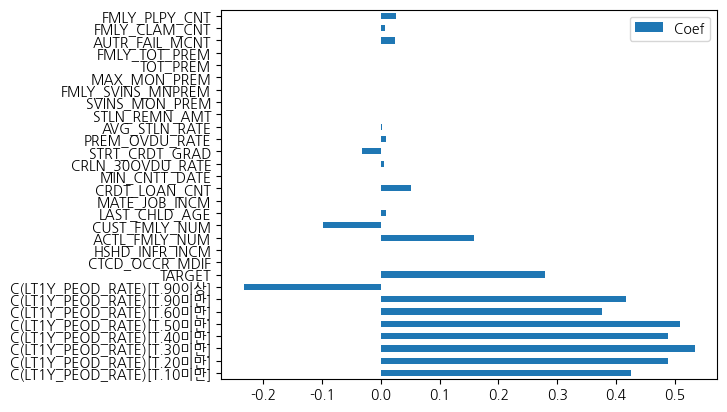

In [78]:
#설명변수 중요도
data_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
data_logistic_coef.plot.barh(y="Coef")

## 의사결정나무

In [7]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

matplotlib.rc("font", family="NanumGothic")
matplotlib.rc("axes", unicode_minus=False)

In [8]:
data = pd.read_csv('/home/piai/빅데이터 프로젝트/Postprocessing.csv', index_col=0)
data

# # 양육기 전, 양육기, 양육기 후로 막내자녀나이 분류
# data['양육기2'] = ''

# data.loc[(data['LAST_CHLD_AGE'] == 0), "양육기2"] = "양육기 전"
# data.loc[((data['LAST_CHLD_AGE'] > 0) & (data['LAST_CHLD_AGE'] <= 20)), "양육기2"] = "양육기"
# data.loc[(data['LAST_CHLD_AGE'] > 20), "양육기2"] = "양육기 후"

# #특정 열 이름
# column_name = 'OCCP_NAME_G'
# #해당 열 추출
# occupation_column = data[column_name]
# def classify_occupation(occupation):
#     if occupation in ['기업/단체 임원', '고소득 전문직', '전문직']:
#         return '고소득 전문직'
#     elif occupation in ['단순 사무직', '사무직', '공무원']:
#         return '사무직 및 관리직'
#     elif occupation in ['3차산업 종사자', '자영업']:
#         return '서비스 및 판매직'
#     elif occupation in ['2차산업 종사자', '1차산업 종사자', '운전직', '단순노무직']:
#         return '기술직 및 생산직'
#     elif occupation in ['예체능계 종사자']:
#         return '예체능계 종사자'
#     else:
#         return '학생 및 비경제 활동/기타'# 'OCCP_NAME_G' 컬럼을 바탕으로 새로운 '직업재분류' 컬럼 생성
# data['직업재분류'] = data['OCCP_NAME_G'].apply(classify_occupation)# 새로운 분류를 저장할 컬럼 추가
# data['직업재분류'] = occupation_column.apply(classify_occupation)# 결과 확인
# print(data[['OCCP_NAME_G', '직업재분류']])

data.rename(columns={'TERM/MAIN': 'TERM_MAIN'}, inplace=True)

data = data[data['AGE'] != "*"]

# CUST_ID 컬럼 제거
data.drop(columns=['CUST_ID','CNTT_LAMT_CNT'], inplace=True)
data

,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,CRDT_OCCR_MDIF,...,LT1Y_CTLT_CNT,AUTR_FAIL_MCNT,FYCM_PAID_AMT,FMLY_CLAM_CNT,FMLY_PLPY_CNT,AGE,SEX,양육기,양육기간,TERM_MAIN
0,0,1,0,0,0,9001,9001,9001,0,1,...,0,10,0,0,0,50,1,0,6.0,0
1,0,1,0,0,0,24001,0,24001,0,0,...,0,0,300000,2,5,50,1,0,1.0,0
2,0,0,1,3,2,15001,9001,0,3001,1,...,0,0,0,0,2,60,2,0,0.0,0
3,1,0,2,4,2,6001,3001,0,3001,1,...,0,0,0,0,1,35,1,0,0.0,0
4,0,4,0,0,0,21001,15001,21001,0,1,...,0,0,500000,2,1,45,1,1,16.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100228,0,1,0,2,2,75001,15001,57001,0,37,...,0,1,700000,0,3,55,2,0,0.0,0
100229,0,2,0,0,0,54001,9001,54001,0,85,...,0,0,100000,0,3,45,2,1,11.0,0
100230,0,1,0,0,0,27001,27001,27001,0,1,...,0,1,0,0,4,45,1,1,16.0,0
100231,0,0,0,1,1,57001,0,0,0,1,...,0,0,0,0,0,45,1,0,0.0,0


In [9]:
data_dummy = pd.get_dummies(data)
data_dummy.head()

,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,CRDT_OCCR_MDIF,...,AGE_35,AGE_40,AGE_45,AGE_50,AGE_55,AGE_60,AGE_65,AGE_70,SEX_1,SEX_2
0,0,1,0,0,0,9001,9001,9001,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,0,24001,0,24001,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,1,3,2,15001,9001,0,3001,1,...,0,0,0,0,0,1,0,0,0,1
3,1,0,2,4,2,6001,3001,0,3001,1,...,1,0,0,0,0,0,0,0,1,0
4,0,4,0,0,0,21001,15001,21001,0,1,...,0,0,1,0,0,0,0,0,1,0


In [10]:
data_x = data_dummy.drop('TERM_MAIN', axis=1, inplace=False)
data_y = data_dummy['TERM_MAIN']


data_train_x, data_test_x, data_train_y, data_test_y = train_test_split(
    data_x, data_y, test_size=0.3, random_state=1234)


print("분할 전: ", data_x.shape)
print("분할 후: train: {}, test: {}".format(data_train_x.shape, data_test_x.shape))

분할 전:  (99803, 106)
분할 후: train: (69862, 106), test: (29941, 106)


In [12]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto')

x_resampled, y_resampled = sm.fit_resample(data_train_x, data_train_y)

In [36]:
data['TERM_MAIN'].value_counts()

0    91515
1     8288
Name: TERM_MAIN, dtype: int64

- 목표변수 TERM_MAIN의 클래스 비율이 10:1로 1이 소수 클래스여서 train_score와 test_score가 1이 나온다.
- SMOTE 적용 필요

In [13]:
# 디폴트 의사결정나무 성능 확인
tree_uncust = DecisionTreeClassifier(random_state=1234)
tree_uncust.fit(x_resampled, y_resampled)

print("Train Accuracy: {0:.3f}, Test Acuracy: {1:.3f}".format(tree_uncust.score(x_resampled, y_resampled), \
                                                   tree_uncust.score(data_test_x, data_test_y)))

# print("Test Accuracy: {:.3f}".format(tree_uncust.score(data_test_x, data_test_y)))

Train Accuracy: 1.000, Test Acuracy: 0.868


In [19]:
train_accuracy = []; test_accuracy = []

para_depth = [depth for depth in range(3,12)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state=1234)
    tree.fit(x_resampled, y_resampled)
    train_accuracy.append(tree.score(x_resampled, y_resampled))
    test_accuracy.append(tree.score(data_test_x, data_test_y))
    
data_accuracy_depth = pd.DataFrame()
data_accuracy_depth['Depth'] = para_depth
data_accuracy_depth['TrainAccuracy'] = train_accuracy
data_accuracy_depth['TestAccuracy'] = test_accuracy
data_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,3,0.793,0.856
1,4,0.818,0.806
2,5,0.835,0.809
3,6,0.851,0.841
4,7,0.875,0.852
5,8,0.893,0.894
6,9,0.910,0.900
7,10,0.922,0.910
8,11,0.931,0.912


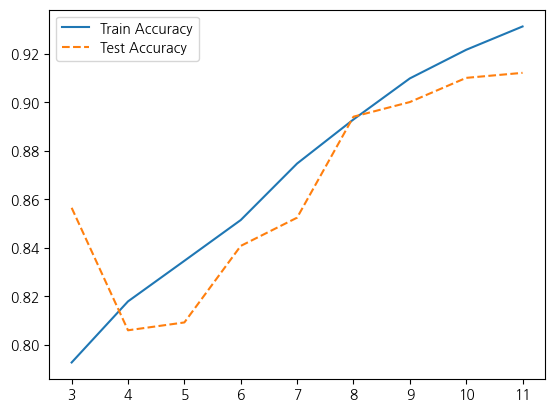

In [20]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

- max_depth = 10

In [21]:
v_feature_name = data_train_x.columns

train_accuracy = []; test_accuracy = []

para_split = [n_split *10 for n_split in range(2,25)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(max_depth = 10, min_samples_split=v_min_samples_split, random_state=1234)
    tree.fit(x_resampled, y_resampled)
    train_accuracy.append(tree.score(x_resampled, y_resampled))
    test_accuracy.append(tree.score(data_test_x, data_test_y))
    
data_accuracy_split = pd.DataFrame()
data_accuracy_split['MinSamplesSplit'] = para_split
data_accuracy_split['TrainAccuracy'] = train_accuracy
data_accuracy_split['TestAccuracy'] = test_accuracy
data_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.921,0.910
1,30,0.921,0.910
2,40,0.921,0.911
3,50,0.921,0.911
4,60,0.920,0.910
5,70,0.920,0.910
6,80,0.920,0.910
7,90,0.920,0.910
8,100,0.920,0.910
9,110,0.919,0.910


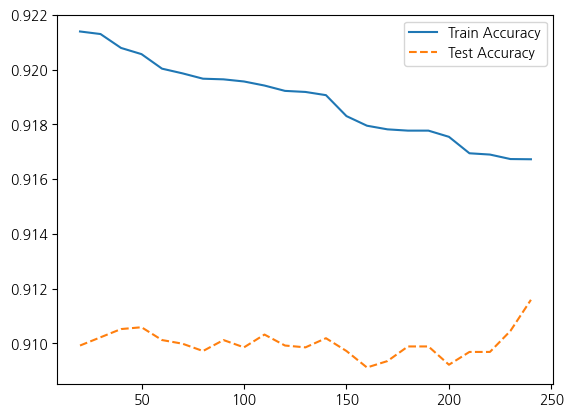

In [22]:
plt.plot(para_split, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

- min_samples_split = 60

In [23]:
train_accuracy = []; test_accuracy = []

para_leaf = [n_leaf *2 for n_leaf in range(5,26)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(max_depth = 10, min_samples_split=60, min_samples_leaf=v_min_samples_leaf, random_state=1234)
    tree.fit(x_resampled, y_resampled)
    train_accuracy.append(tree.score(x_resampled, y_resampled))
    test_accuracy.append(tree.score(data_test_x, data_test_y))
    
data_accuracy_leaf = pd.DataFrame()
data_accuracy_leaf['MinSamplesSplit'] = para_leaf
data_accuracy_leaf['TrainAccuracy'] = train_accuracy
data_accuracy_leaf['TestAccuracy'] = test_accuracy
data_accuracy_leaf.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.919,0.909
1,12,0.919,0.909
2,14,0.918,0.909
3,16,0.918,0.909
4,18,0.918,0.909
5,20,0.918,0.909
6,22,0.918,0.909
7,24,0.918,0.909
8,26,0.918,0.909
9,28,0.918,0.909


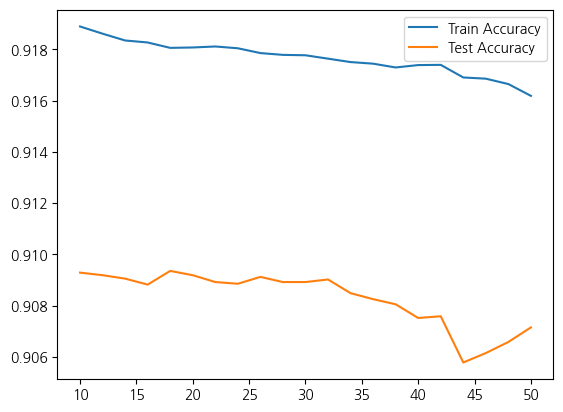

In [24]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="-", label = "Test Accuracy")
plt.legend()

- min_samples_leaf = 10

In [25]:
# 최종 모델
tree_final = DecisionTreeClassifier(max_depth=6, min_samples_split=60, min_samples_leaf=10, random_state=1234)
tree_final.fit(x_resampled, y_resampled)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=60,
                       random_state=1234)

In [26]:
y_pred = tree_final.predict(data_test_x)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(data_test_x, data_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(data_test_y, y_pred)))

print(classification_report(data_test_y, y_pred, digits=3))

Test Accuracy: 0.841

Test Confusion matrix: 
[[24200  3255]
 [ 1519   967]]
              precision    recall  f1-score   support

           0      0.941     0.881     0.910     27455
           1      0.229     0.389     0.288      2486

    accuracy                          0.841     29941
   macro avg      0.585     0.635     0.599     29941
weighted avg      0.882     0.841     0.859     29941



In [49]:
data_importance = pd.DataFrame()
data_importance['Feature'] = v_feature_name
data_importance["Importance"] = tree_final.feature_importances_

data_importance.sort_values("Importance", ascending=False, inplace=True)
data_importance.round(3)

,Feature,Importance
42,LT1Y_CTLT_CNT,0.774
39,MAX_MON_PREM,0.125
30,PREM_OVDU_RATE,0.041
40,TOT_PREM,0.014
19,LAST_CHLD_AGE,0.012
...,...,...
34,LT1Y_SLOD_RATE,0.000
33,LT1Y_STLN_AMT,0.000
32,STLN_REMN_AMT,0.000
29,LTST_CRDT_GRAD,0.000


Text(0, 0.5, '설명변수')

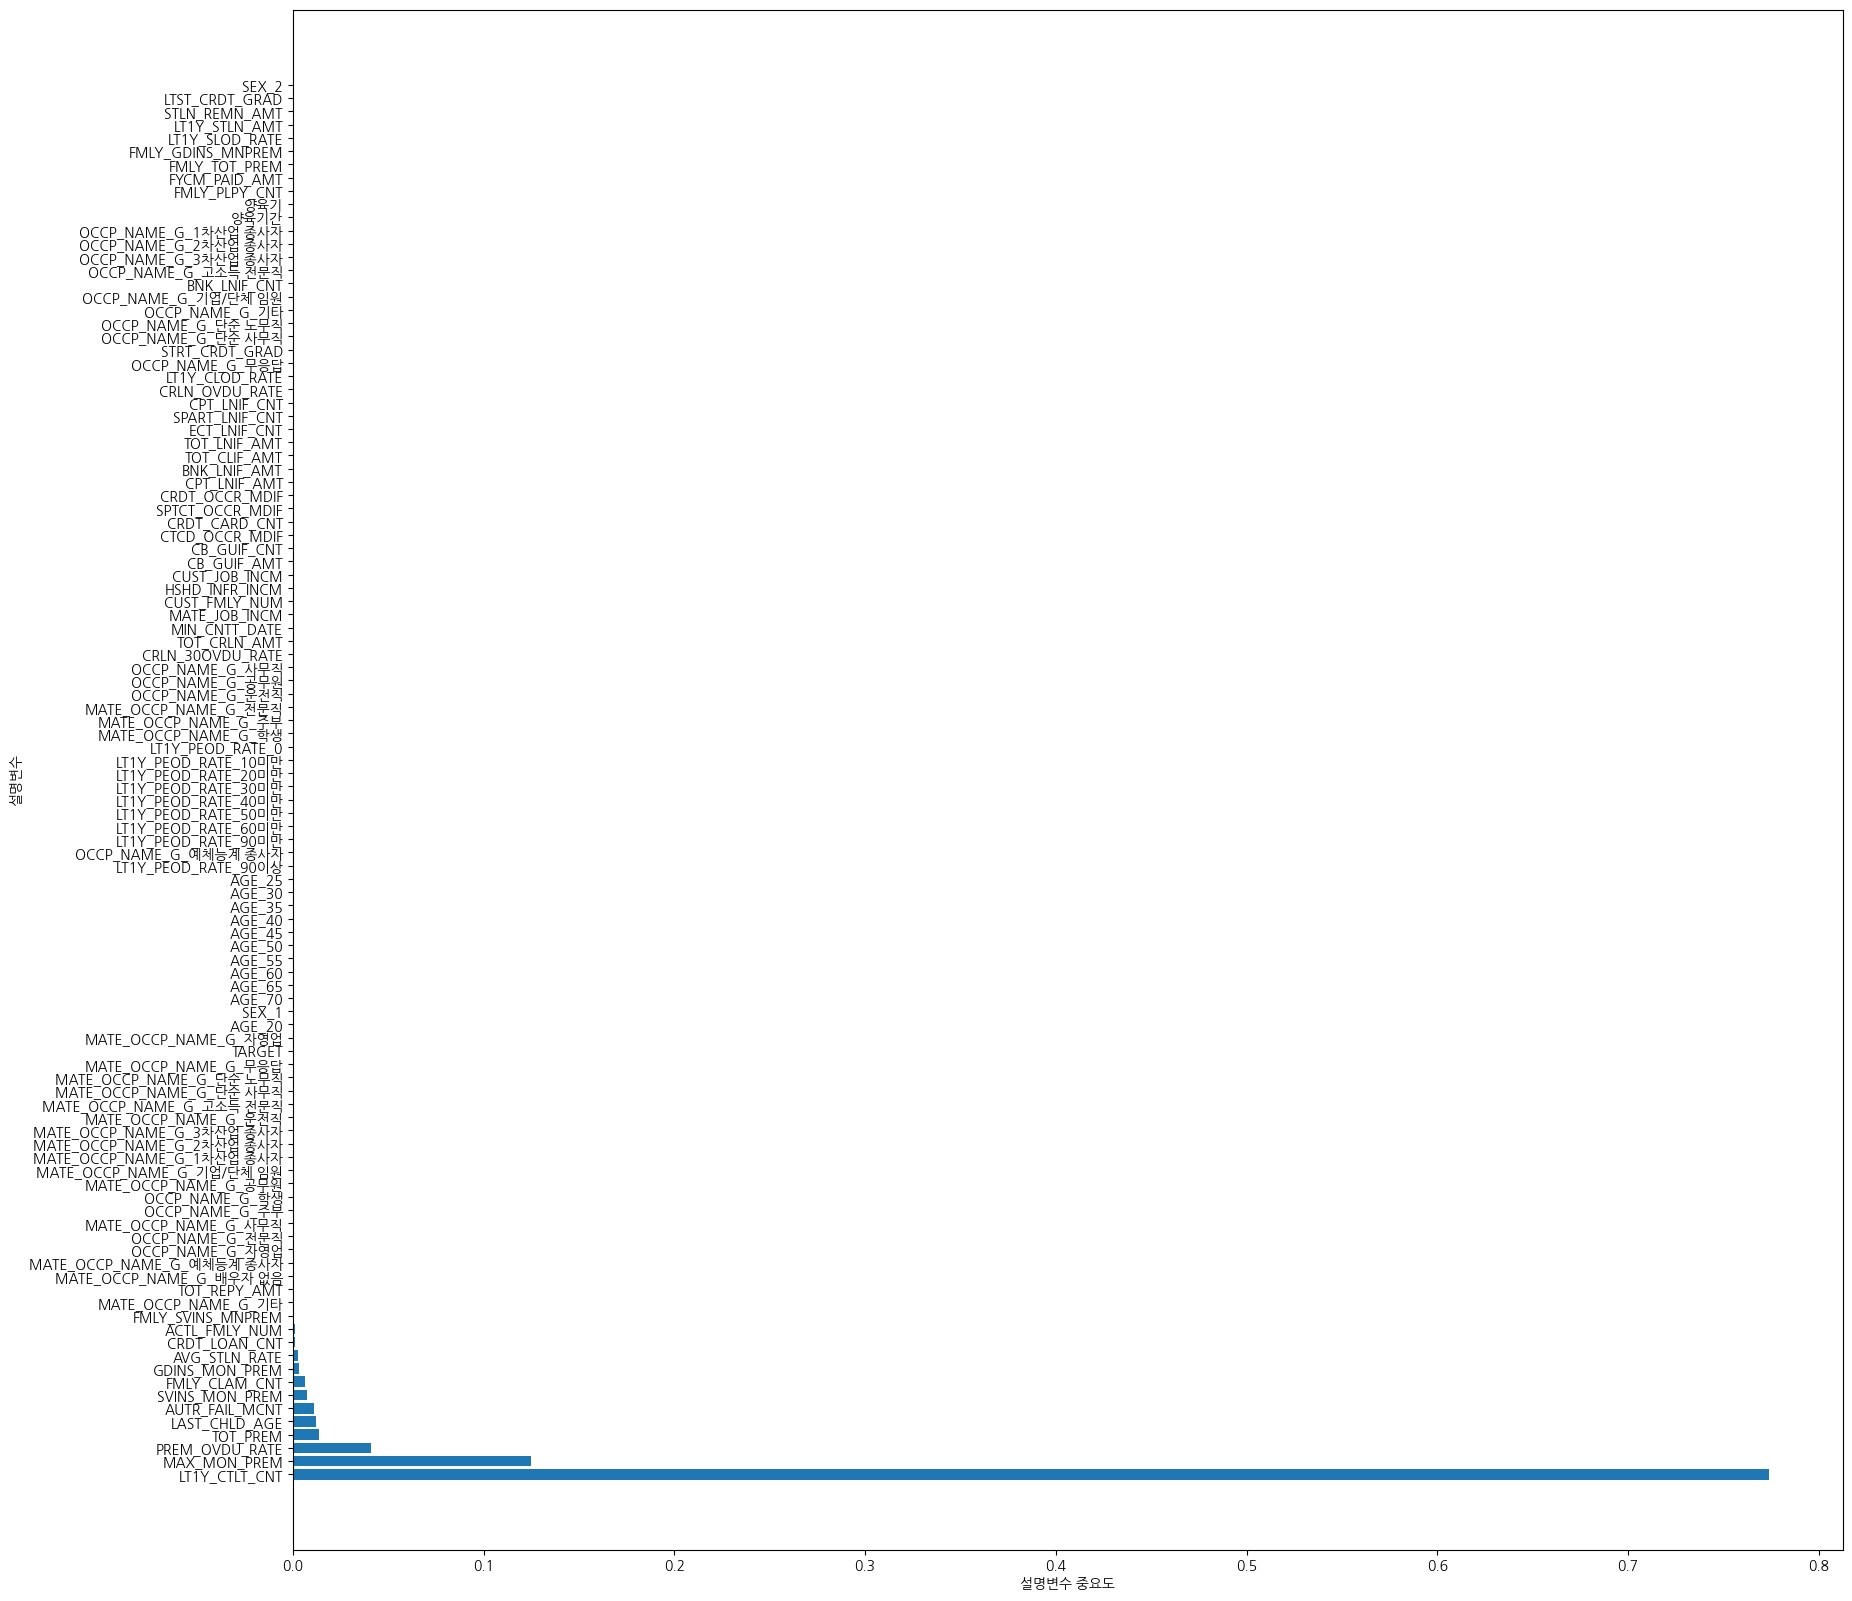

In [55]:
plt.figure(figsize=(20, 20))
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(data_importance))
plt.barh(y = coordinates, width=data_importance["Importance"])
plt.yticks(coordinates, data_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

- 최근1년실효해지건수와 최대월납입보험료, 보험료연체율이 중요한 설명변수이다.
- 최근1년실효해지건수가 다른 설명변수에 비해 매우 중요도가 크다.
- 빼고 다시 돌려보자

In [54]:
sm = SMOTE(sampling_strategy='auto')

x_resampled, y_resampled = sm.fit_resample(data_x, data_y)

In [55]:
data_train_x_over, data_test_x_over, data_train_y_over, data_test_y_over = train_test_split(
    x_resampled, y_resampled, test_size=0.3, random_state=1234)


print("분할 전: ", x_resampled.shape)
print("분할 후: train: {}, test: {}".format(data_train_x_over.shape, data_test_x_over.shape))

분할 전:  (183030, 106)
분할 후: train: (128121, 106), test: (54909, 106)


In [56]:
# 디폴트 의사결정나무 성능 확인
tree_uncust = DecisionTreeClassifier(random_state=1234)
tree_uncust.fit(data_train_x_over, data_train_y_over)

print("Train Accuracy: {0:.3f}, Test Acuracy: {1:.3f}".format(tree_uncust.score(data_train_x_over, data_train_y_over), \
                                                   tree_uncust.score(data_test_x_over, data_test_y_over)))

# print("Test Accuracy: {:.3f}".format(tree_uncust.score(data_test_x, data_test_y)))

Train Accuracy: 1.000, Test Acuracy: 0.923


In [57]:
train_accuracy = []; test_accuracy = []

para_depth = [depth for depth in range(3,12)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state=1234)
    tree.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(tree.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(tree.score(data_test_x_over, data_test_y_over))
    
data_accuracy_depth = pd.DataFrame()
data_accuracy_depth['Depth'] = para_depth
data_accuracy_depth['TrainAccuracy'] = train_accuracy
data_accuracy_depth['TestAccuracy'] = test_accuracy
data_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,3,0.777,0.779
1,4,0.848,0.849
2,5,0.857,0.859
3,6,0.868,0.871
4,7,0.891,0.893
5,8,0.907,0.909
6,9,0.917,0.915
7,10,0.929,0.925
8,11,0.936,0.930


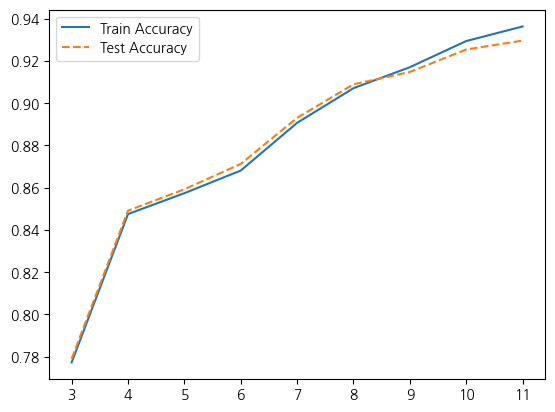

In [58]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [59]:
v_feature_name = data_train_x_over.columns

train_accuracy = []; test_accuracy = []

para_split = [n_split *10 for n_split in range(2,25)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(max_depth = 11, min_samples_split=v_min_samples_split, random_state=1234)
    tree.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(tree.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(tree.score(data_test_x_over, data_test_y_over))
    
data_accuracy_split = pd.DataFrame()
data_accuracy_split['MinSamplesSplit'] = para_split
data_accuracy_split['TrainAccuracy'] = train_accuracy
data_accuracy_split['TestAccuracy'] = test_accuracy
data_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.935,0.930
1,30,0.935,0.930
2,40,0.934,0.929
3,50,0.934,0.930
4,60,0.934,0.930
5,70,0.933,0.929
6,80,0.933,0.930
7,90,0.933,0.929
8,100,0.932,0.929
9,110,0.932,0.929


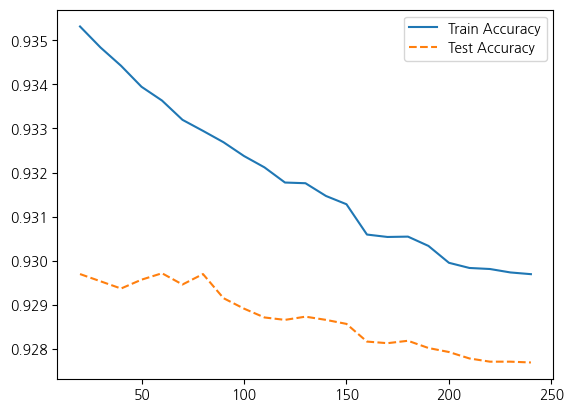

In [60]:
plt.plot(para_split, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [61]:
train_accuracy = []; test_accuracy = []

para_leaf = [n_leaf *2 for n_leaf in range(5,26)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(max_depth = 11, min_samples_split=20, min_samples_leaf=v_min_samples_leaf, random_state=1234)
    tree.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(tree.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(tree.score(data_test_x_over, data_test_y_over))
    
data_accuracy_leaf = pd.DataFrame()
data_accuracy_leaf['MinSamplesSplit'] = para_leaf
data_accuracy_leaf['TrainAccuracy'] = train_accuracy
data_accuracy_leaf['TestAccuracy'] = test_accuracy
data_accuracy_leaf.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.934,0.929
1,12,0.934,0.929
2,14,0.934,0.929
3,16,0.934,0.929
4,18,0.933,0.928
5,20,0.932,0.927
6,22,0.932,0.927
7,24,0.931,0.927
8,26,0.931,0.927
9,28,0.931,0.927


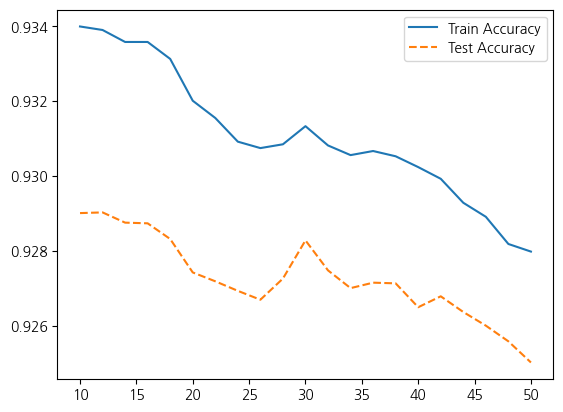

In [62]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [63]:
# 최종 모델
tree_final = DecisionTreeClassifier(max_depth=11, min_samples_split=20, min_samples_leaf=10, random_state=1234)
tree_final.fit(data_train_x_over, data_train_y_over)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=10, min_samples_split=20,
                       random_state=1234)

In [64]:
y_pred = tree_final.predict(data_test_x_over)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(data_test_x_over, data_test_y_over)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(data_test_y_over, y_pred)))

print(classification_report(data_test_y_over, y_pred, digits=3))

Test Accuracy: 0.929

Test Confusion matrix: 
[[26878   653]
 [ 3245 24133]]
              precision    recall  f1-score   support

           0      0.892     0.976     0.932     27531
           1      0.974     0.881     0.925     27378

    accuracy                          0.929     54909
   macro avg      0.933     0.929     0.929     54909
weighted avg      0.933     0.929     0.929     54909



# 랜덤포레스트

In [36]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

matplotlib.rc("font", family="NanumGothic")
matplotlib.rc("axes", unicode_minus=False)

from sklearn.ensemble import RandomForestClassifier

In [37]:
data = pd.read_csv('/home/piai/빅데이터 프로젝트/Postprocessing.csv', index_col=0)
data

# # 양육기 전, 양육기, 양육기 후로 막내자녀나이 분류
# data['양육기2'] = ''

# data.loc[(data['LAST_CHLD_AGE'] == 0), "양육기2"] = "양육기 전"
# data.loc[((data['LAST_CHLD_AGE'] > 0) & (data['LAST_CHLD_AGE'] <= 20)), "양육기2"] = "양육기"
# data.loc[(data['LAST_CHLD_AGE'] > 20), "양육기2"] = "양육기 후"

# #특정 열 이름
# column_name = 'OCCP_NAME_G'
# #해당 열 추출
# occupation_column = data[column_name]
# def classify_occupation(occupation):
#     if occupation in ['기업/단체 임원', '고소득 전문직', '전문직']:
#         return '고소득 전문직'
#     elif occupation in ['단순 사무직', '사무직', '공무원']:
#         return '사무직 및 관리직'
#     elif occupation in ['3차산업 종사자', '자영업']:
#         return '서비스 및 판매직'
#     elif occupation in ['2차산업 종사자', '1차산업 종사자', '운전직', '단순노무직']:
#         return '기술직 및 생산직'
#     elif occupation in ['예체능계 종사자']:
#         return '예체능계 종사자'
#     else:
#         return '학생 및 비경제 활동/기타'# 'OCCP_NAME_G' 컬럼을 바탕으로 새로운 '직업재분류' 컬럼 생성
# data['직업재분류'] = data['OCCP_NAME_G'].apply(classify_occupation)# 새로운 분류를 저장할 컬럼 추가
# data['직업재분류'] = occupation_column.apply(classify_occupation)# 결과 확인
# print(data[['OCCP_NAME_G', '직업재분류']])

data.rename(columns={'TERM/MAIN': 'TERM_MAIN'}, inplace=True)

data = data[data['AGE'] != "*"]

# CUST_ID 컬럼 제거
data.drop(columns=['CUST_ID','CNTT_LAMT_CNT'], inplace=True)
data

,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,CRDT_OCCR_MDIF,...,LT1Y_CTLT_CNT,AUTR_FAIL_MCNT,FYCM_PAID_AMT,FMLY_CLAM_CNT,FMLY_PLPY_CNT,AGE,SEX,양육기,양육기간,TERM_MAIN
0,0,1,0,0,0,9001,9001,9001,0,1,...,0,10,0,0,0,50,1,0,6.0,0
1,0,1,0,0,0,24001,0,24001,0,0,...,0,0,300000,2,5,50,1,0,1.0,0
2,0,0,1,3,2,15001,9001,0,3001,1,...,0,0,0,0,2,60,2,0,0.0,0
3,1,0,2,4,2,6001,3001,0,3001,1,...,0,0,0,0,1,35,1,0,0.0,0
4,0,4,0,0,0,21001,15001,21001,0,1,...,0,0,500000,2,1,45,1,1,16.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100228,0,1,0,2,2,75001,15001,57001,0,37,...,0,1,700000,0,3,55,2,0,0.0,0
100229,0,2,0,0,0,54001,9001,54001,0,85,...,0,0,100000,0,3,45,2,1,11.0,0
100230,0,1,0,0,0,27001,27001,27001,0,1,...,0,1,0,0,4,45,1,1,16.0,0
100231,0,0,0,1,1,57001,0,0,0,1,...,0,0,0,0,0,45,1,0,0.0,0


In [38]:
data_dummy = pd.get_dummies(data)
data_dummy.head()

,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,CRDT_OCCR_MDIF,...,AGE_35,AGE_40,AGE_45,AGE_50,AGE_55,AGE_60,AGE_65,AGE_70,SEX_1,SEX_2
0,0,1,0,0,0,9001,9001,9001,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,0,24001,0,24001,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,1,3,2,15001,9001,0,3001,1,...,0,0,0,0,0,1,0,0,0,1
3,1,0,2,4,2,6001,3001,0,3001,1,...,1,0,0,0,0,0,0,0,1,0
4,0,4,0,0,0,21001,15001,21001,0,1,...,0,0,1,0,0,0,0,0,1,0


In [39]:
# pd.set_option('display.max_columns', None)

In [40]:
data_x = data_dummy.drop('TERM_MAIN', axis=1, inplace=False)
data_y = data_dummy['TERM_MAIN']

data_train_x, data_test_x, data_train_y, data_test_y = train_test_split(data_x, data_y, test_size=0.3, random_state=1234)

print("분할 전: ", data_x.shape)
print("분할 후: train: {}, test: {}".format(data_train_x.shape, data_test_x.shape))

분할 전:  (99803, 106)
분할 후: train: (69862, 106), test: (29941, 106)


In [41]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto')

x_resampled, y_resampled = sm.fit_resample(data_train_x, data_train_y)

In [42]:
# 디폴트 랜덤포레스트 모델 성능
rf_uncust = RandomForestClassifier(random_state=1234)
rf_uncust.fit(x_resampled, y_resampled)

print("Train Accuracy: {0:.3f}, Test Acuracy: {1:.3f}".format(rf_uncust.score(x_resampled, y_resampled), \
                                                   rf_uncust.score(data_test_x, data_test_y)))

Train Accuracy: 1.000, Test Acuracy: 0.930


In [43]:
train_accuracy = []; test_accuracy = []

para_depth = [depth for depth in range(3,12)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_max_depth, random_state=1234)
    rf.fit(x_resampled, y_resampled)
    train_accuracy.append(rf.score(x_resampled, y_resampled))
    test_accuracy.append(rf.score(data_test_x, data_test_y))
    
data_accuracy_depth = pd.DataFrame()
data_accuracy_depth['Depth'] = para_depth
data_accuracy_depth['TrainAccuracy'] = train_accuracy
data_accuracy_depth['TestAccuracy'] = test_accuracy
data_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,3,0.811,0.767
1,4,0.835,0.791
2,5,0.861,0.820
3,6,0.879,0.838
4,7,0.904,0.869
5,8,0.919,0.883
6,9,0.931,0.895
7,10,0.941,0.905
8,11,0.951,0.913


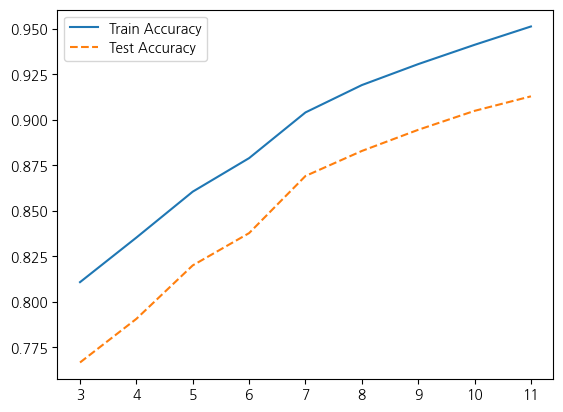

In [44]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

- max_depth = 11

In [45]:
train_accuracy = []; test_accuracy = []

para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(max_depth = 11,n_estimators=v_n_estimators, random_state=1234)
    rf.fit(x_resampled, y_resampled)
    train_accuracy.append(rf.score(x_resampled, y_resampled))
    test_accuracy.append(rf.score(data_test_x, data_test_y))
    
data_accuracy_n = pd.DataFrame()
data_accuracy_n['n_estimators'] = para_n_tree
data_accuracy_n['TrainAccuracy'] = train_accuracy
data_accuracy_n['TestAccuracy'] = test_accuracy
data_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.942,0.900
1,20,0.948,0.908
2,30,0.949,0.908
3,40,0.950,0.909
4,50,0.950,0.911
5,60,0.951,0.912
6,70,0.951,0.911
7,80,0.951,0.912
8,90,0.951,0.912
9,100,0.951,0.913


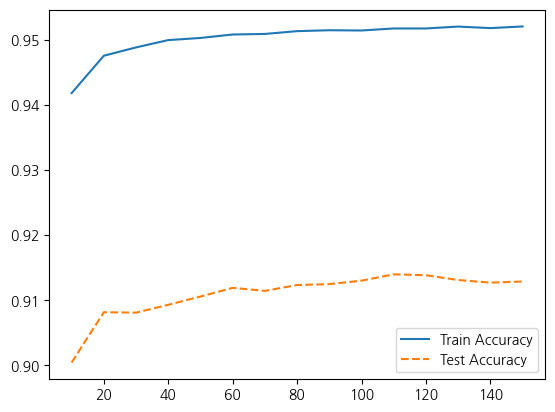

In [46]:
plt.plot(para_n_tree, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

- n_estimators=100

In [47]:
train_accuracy = []; test_accuracy = []

para_split = [n_split*10 for n_split in range(1,15)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(max_depth = 7,n_estimators=100, min_samples_split=v_min_samples_split, random_state=1234)
    rf.fit(x_resampled, y_resampled)
    train_accuracy.append(rf.score(x_resampled, y_resampled))
    test_accuracy.append(rf.score(data_test_x, data_test_y))
    
data_accuracy_split = pd.DataFrame()
data_accuracy_split['min_samples_split'] = para_split
data_accuracy_split['TrainAccuracy'] = train_accuracy
data_accuracy_split['TestAccuracy'] = test_accuracy
data_accuracy_split.round(3)

,min_samples_split,TrainAccuracy,TestAccuracy
0,10,0.904,0.866
1,20,0.903,0.867
2,30,0.902,0.866
3,40,0.902,0.866
4,50,0.904,0.869
5,60,0.902,0.865
6,70,0.902,0.865
7,80,0.902,0.865
8,90,0.902,0.866
9,100,0.904,0.868


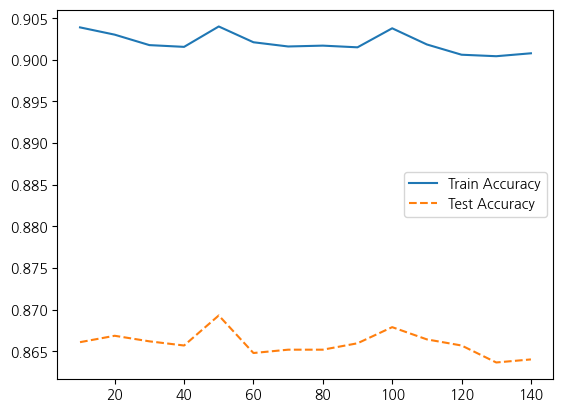

In [48]:
plt.plot(para_split, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

- min_samples_split = 50

In [49]:
train_accuracy = []; test_accuracy = []

para_leaf = [n_leaf*5 for n_leaf in range(1,15)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(max_depth = 7,n_estimators=100, min_samples_split=50,
                                min_samples_leaf=v_min_samples_leaf, random_state=1234)
    rf.fit(x_resampled, y_resampled)
    train_accuracy.append(rf.score(x_resampled, y_resampled))
    test_accuracy.append(rf.score(data_test_x, data_test_y))
    
data_accuracy_leaf = pd.DataFrame()
data_accuracy_leaf['min_samples_leaf'] = para_leaf
data_accuracy_leaf['TrainAccuracy'] = train_accuracy
data_accuracy_leaf['TestAccuracy'] = test_accuracy
data_accuracy_leaf.round(3)

,min_samples_leaf,TrainAccuracy,TestAccuracy
0,5,0.904,0.867
1,10,0.903,0.866
2,15,0.903,0.866
3,20,0.902,0.866
4,25,0.900,0.863
5,30,0.898,0.860
6,35,0.901,0.864
7,40,0.897,0.859
8,45,0.899,0.859
9,50,0.898,0.859


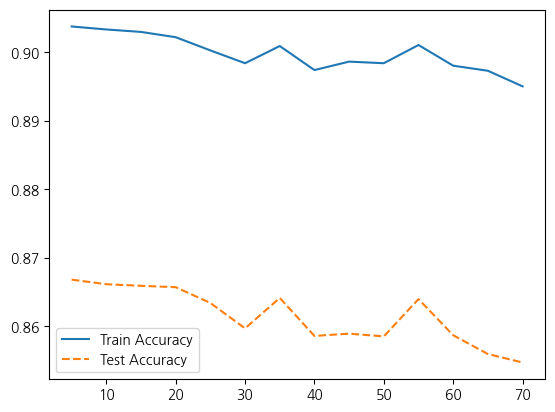

In [50]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

- min_samples_leaf = 5

In [51]:
# 최종 모델
rf_final = RandomForestClassifier(max_depth=7, n_estimators=100, min_samples_split=50,
                                  min_samples_leaf=5, random_state=1234)
rf_final.fit(x_resampled, y_resampled)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=50,
                       random_state=1234)

In [52]:
y_pred = rf_final.predict(data_test_x)

print("Test Accuracy: {0:.3f}\n".format(rf_final.score(data_test_x, data_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(data_test_y, y_pred)))

print(classification_report(data_test_y, y_pred, digits=3))

Test Accuracy: 0.867

Test Confusion matrix: 
[[25001  2375]
 [ 1612   953]]
              precision    recall  f1-score   support

           0      0.939     0.913     0.926     27376
           1      0.286     0.372     0.323      2565

    accuracy                          0.867     29941
   macro avg      0.613     0.642     0.625     29941
weighted avg      0.883     0.867     0.875     29941



In [94]:
v_feature_name = data_train_x.columns

data_importance = pd.DataFrame()
data_importance['Feature'] = v_feature_name
data_importance["Importance"] = rf_final.feature_importances_

data_importance.sort_values("Importance", ascending=False, inplace=True)
data_importance.round(3)

,Feature,Importance
42,LT1Y_CTLT_CNT,0.512
39,MAX_MON_PREM,0.118
43,AUTR_FAIL_MCNT,0.072
30,PREM_OVDU_RATE,0.038
84,LT1Y_PEOD_RATE_0,0.025
...,...,...
83,MATE_OCCP_NAME_G_학생,0.000
93,AGE_20,0.000
103,AGE_70,0.000
58,OCCP_NAME_G_무응답,0.000


Text(0, 0.5, '설명변수')

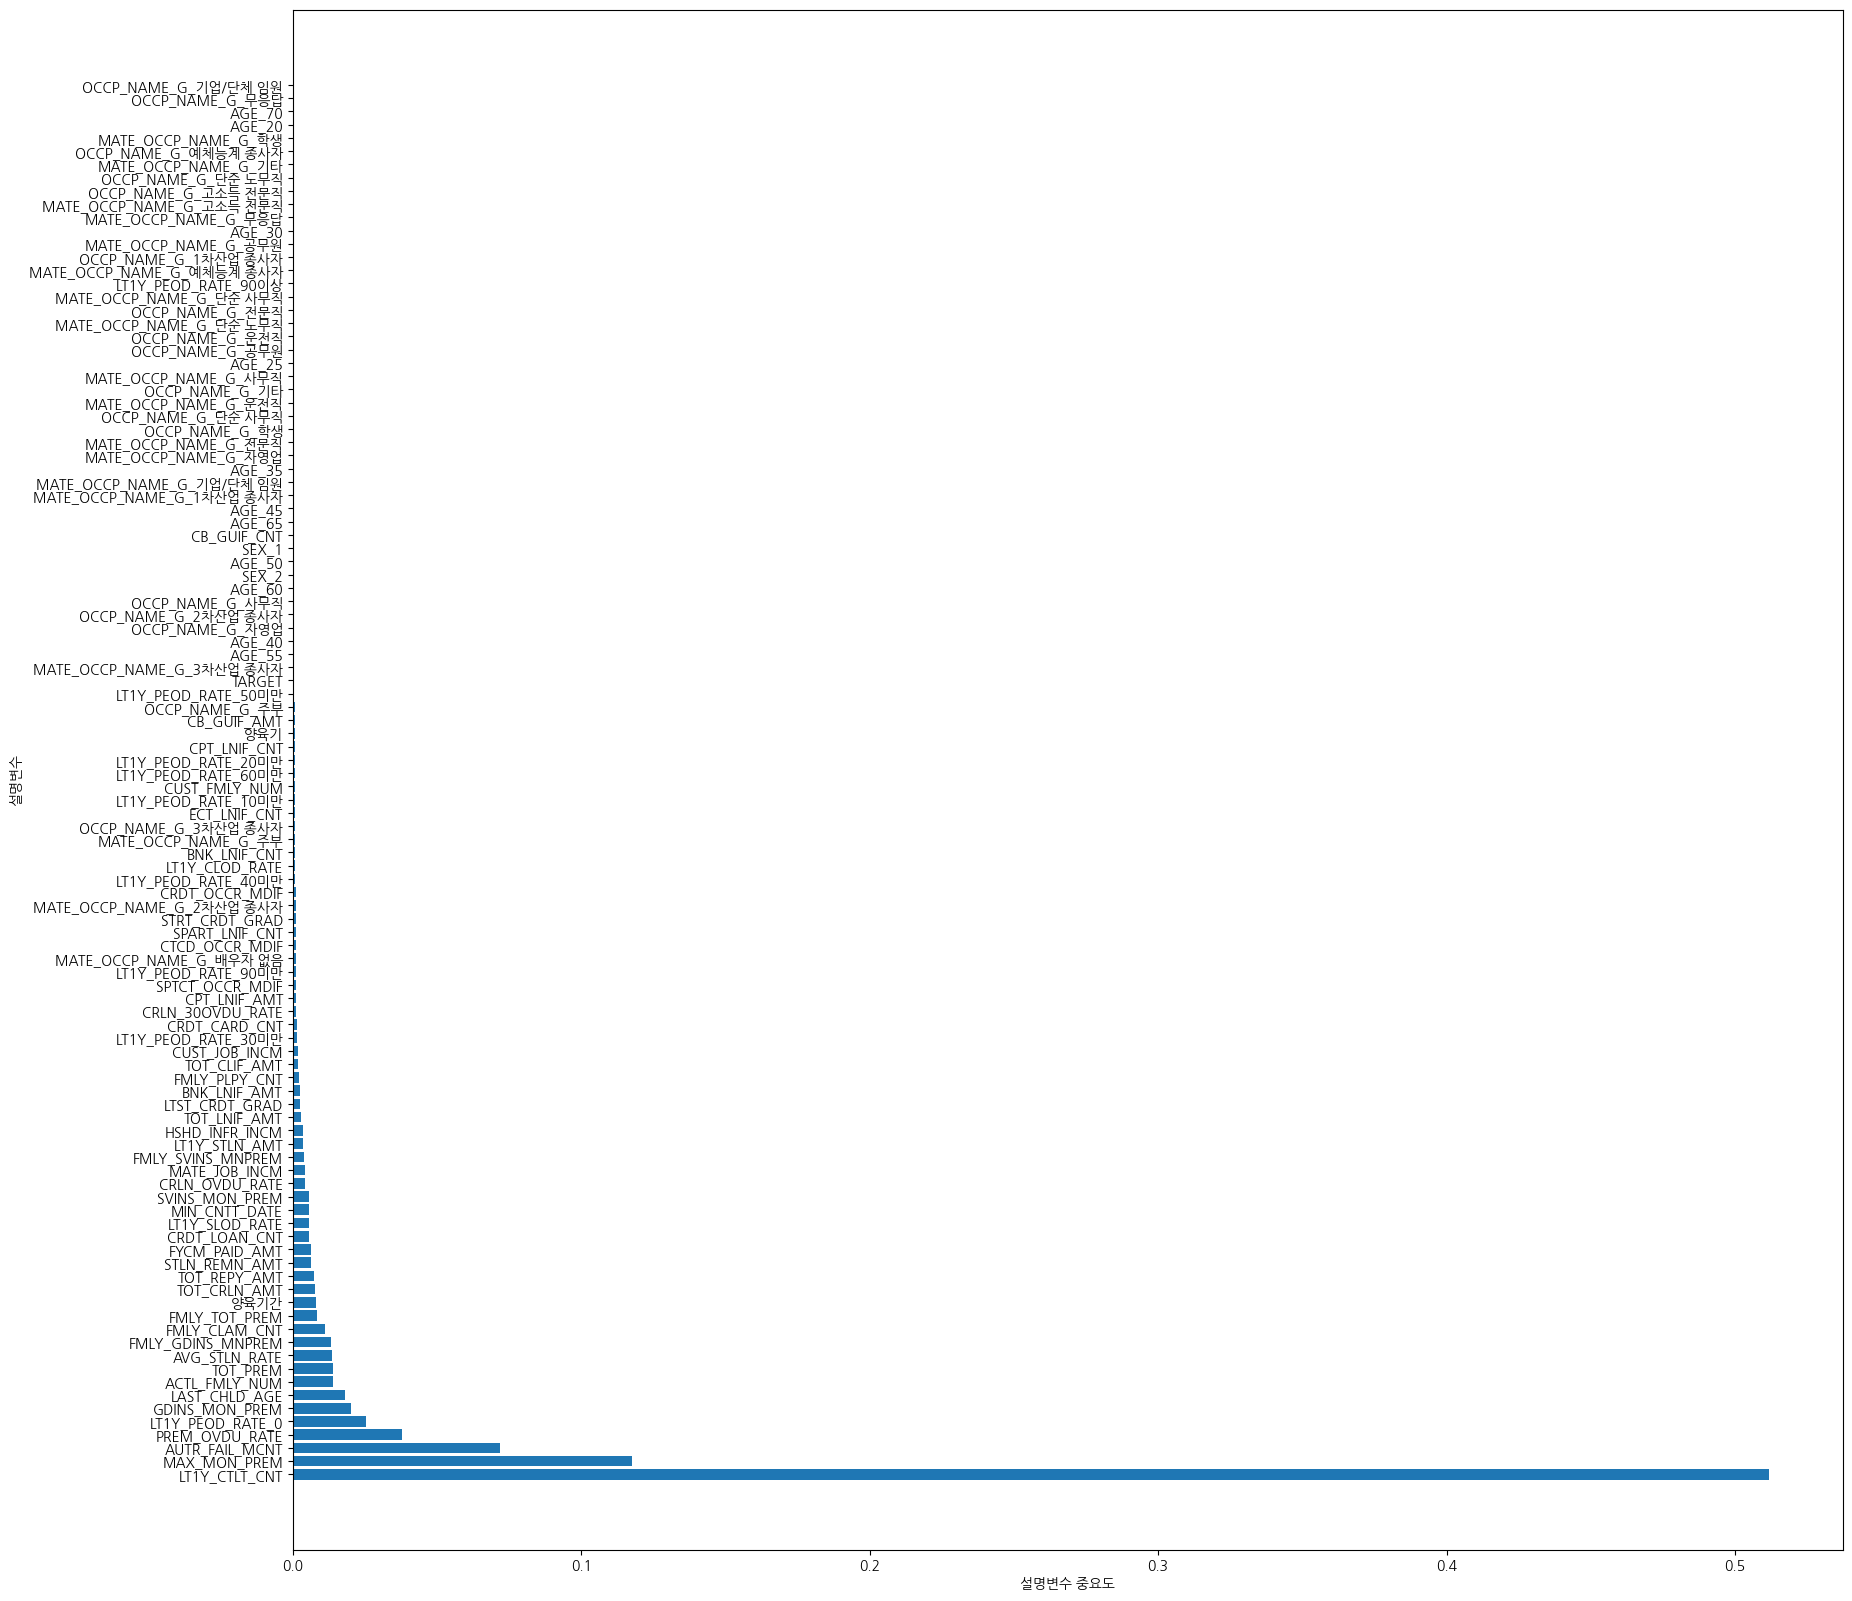

In [95]:
plt.figure(figsize=(20, 20))
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(data_importance))
plt.barh(y = coordinates, width=data_importance["Importance"])
plt.yticks(coordinates, data_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

- 최근1년실효해지건수, 최대월납입보험료, 자동이체실패월수 순으로 설명변수 중요도가 크다.


In [65]:
sm = SMOTE(sampling_strategy='auto')

x_resampled, y_resampled = sm.fit_resample(data_x, data_y)

In [66]:
data_train_x_over, data_test_x_over, data_train_y_over, data_test_y_over = train_test_split(
    x_resampled, y_resampled, test_size=0.3, random_state=1234)


print("분할 전: ", x_resampled.shape)
print("분할 후: train: {}, test: {}".format(data_train_x_over.shape, data_test_x_over.shape))

분할 전:  (183030, 106)
분할 후: train: (128121, 106), test: (54909, 106)


In [69]:
train_accuracy = []; test_accuracy = []

para_depth = [depth for depth in range(3,12)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state=1234)
    tree.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(tree.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(tree.score(data_test_x_over, data_test_y_over))
    
data_accuracy_depth = pd.DataFrame()
data_accuracy_depth['Depth'] = para_depth
data_accuracy_depth['TrainAccuracy'] = train_accuracy
data_accuracy_depth['TestAccuracy'] = test_accuracy
data_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,3,0.778,0.779
1,4,0.848,0.849
2,5,0.857,0.859
3,6,0.868,0.871
4,7,0.891,0.893
5,8,0.905,0.906
6,9,0.917,0.916
7,10,0.931,0.927
8,11,0.937,0.930


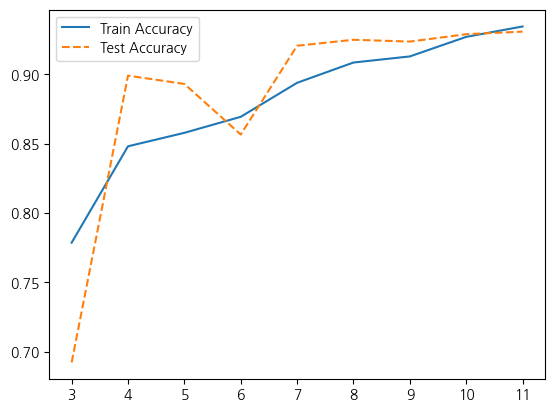

In [68]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [70]:
train_accuracy = []; test_accuracy = []

para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(max_depth = 11,n_estimators=v_n_estimators, random_state=1234)
    rf.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(rf.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(rf.score(data_test_x_over, data_test_y_over))
    
data_accuracy_n = pd.DataFrame()
data_accuracy_n['n_estimators'] = para_n_tree
data_accuracy_n['TrainAccuracy'] = train_accuracy
data_accuracy_n['TestAccuracy'] = test_accuracy
data_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.939,0.933
1,20,0.944,0.938
2,30,0.946,0.941
3,40,0.947,0.942
4,50,0.947,0.941
5,60,0.948,0.942
6,70,0.948,0.943
7,80,0.948,0.943
8,90,0.948,0.943
9,100,0.948,0.943


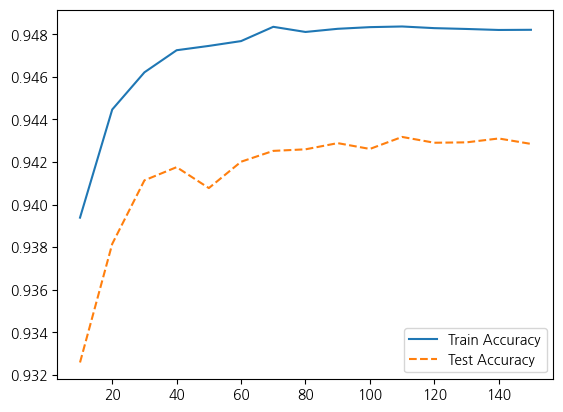

In [73]:
plt.plot(para_n_tree, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [74]:
train_accuracy = []; test_accuracy = []

para_split = [n_split*10 for n_split in range(1,15)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(max_depth = 11,n_estimators=100, min_samples_split=v_min_samples_split, random_state=1234)
    rf.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(rf.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(rf.score(data_test_x_over, data_test_y_over))
    
data_accuracy_split = pd.DataFrame()
data_accuracy_split['min_samples_split'] = para_split
data_accuracy_split['TrainAccuracy'] = train_accuracy
data_accuracy_split['TestAccuracy'] = test_accuracy
data_accuracy_split.round(3)

,min_samples_split,TrainAccuracy,TestAccuracy
0,10,0.947,0.942
1,20,0.947,0.943
2,30,0.946,0.942
3,40,0.946,0.942
4,50,0.945,0.942
5,60,0.944,0.941
6,70,0.944,0.941
7,80,0.945,0.942
8,90,0.943,0.941
9,100,0.943,0.940


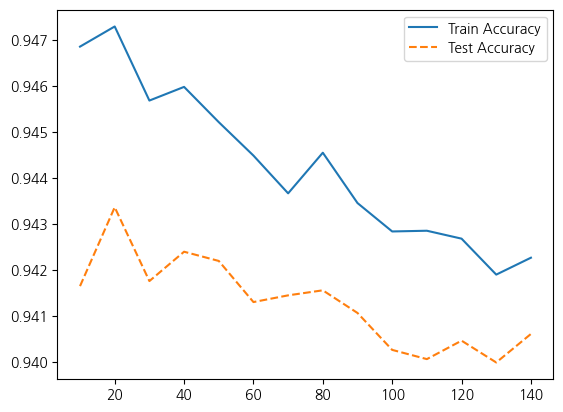

In [75]:
plt.plot(para_split, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [76]:
train_accuracy = []; test_accuracy = []

para_leaf = [n_leaf*5 for n_leaf in range(1,15)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(max_depth = 7,n_estimators=100, min_samples_split=20,
                                min_samples_leaf=v_min_samples_leaf, random_state=1234)
    rf.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(rf.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(rf.score(data_test_x_over, data_test_y_over))
    
data_accuracy_leaf = pd.DataFrame()
data_accuracy_leaf['min_samples_leaf'] = para_leaf
data_accuracy_leaf['TrainAccuracy'] = train_accuracy
data_accuracy_leaf['TestAccuracy'] = test_accuracy
data_accuracy_leaf.round(3)

,min_samples_leaf,TrainAccuracy,TestAccuracy
0,5,0.900,0.900
1,10,0.900,0.901
2,15,0.901,0.902
3,20,0.899,0.899
4,25,0.896,0.896
5,30,0.894,0.893
6,35,0.896,0.896
7,40,0.897,0.898
8,45,0.896,0.897
9,50,0.899,0.899


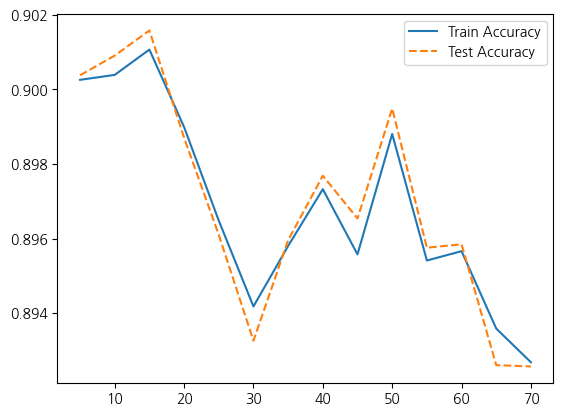

In [77]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [78]:
# 최종 모델
rf_final = RandomForestClassifier(max_depth=7, n_estimators=100, min_samples_split=50,
                                  min_samples_leaf=15, random_state=1234)
rf_final.fit(data_train_x_over, data_train_y_over)

RandomForestClassifier(max_depth=7, min_samples_leaf=15, min_samples_split=50,
                       random_state=1234)

In [79]:
y_pred = rf_final.predict(data_test_x_over)

print("Test Accuracy: {0:.3f}\n".format(rf_final.score(data_test_x, data_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(data_test_y_over, y_pred)))

print(classification_report(data_test_y_over, y_pred, digits=3))

Test Accuracy: 0.867

Test Confusion matrix: 
[[25014  2517]
 [ 3030 24348]]
              precision    recall  f1-score   support

           0      0.892     0.909     0.900     27531
           1      0.906     0.889     0.898     27378

    accuracy                          0.899     54909
   macro avg      0.899     0.899     0.899     54909
weighted avg      0.899     0.899     0.899     54909



# 그래디언트 부스트

In [ ]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

matplotlib.rc("font", family="NanumGothic")
matplotlib.rc("axes", unicode_minus=False)

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
data = pd.read_csv('/home/piai/빅데이터 프로젝트/Postprocessing.csv', index_col=0)
data

# # 양육기 전, 양육기, 양육기 후로 막내자녀나이 분류
# data['양육기2'] = ''

# data.loc[(data['LAST_CHLD_AGE'] == 0), "양육기2"] = "양육기 전"
# data.loc[((data['LAST_CHLD_AGE'] > 0) & (data['LAST_CHLD_AGE'] <= 20)), "양육기2"] = "양육기"
# data.loc[(data['LAST_CHLD_AGE'] > 20), "양육기2"] = "양육기 후"

# #특정 열 이름
# column_name = 'OCCP_NAME_G'
# #해당 열 추출
# occupation_column = data[column_name]
# def classify_occupation(occupation):
#     if occupation in ['기업/단체 임원', '고소득 전문직', '전문직']:
#         return '고소득 전문직'
#     elif occupation in ['단순 사무직', '사무직', '공무원']:
#         return '사무직 및 관리직'
#     elif occupation in ['3차산업 종사자', '자영업']:
#         return '서비스 및 판매직'
#     elif occupation in ['2차산업 종사자', '1차산업 종사자', '운전직', '단순노무직']:
#         return '기술직 및 생산직'
#     elif occupation in ['예체능계 종사자']:
#         return '예체능계 종사자'
#     else:
#         return '학생 및 비경제 활동/기타'# 'OCCP_NAME_G' 컬럼을 바탕으로 새로운 '직업재분류' 컬럼 생성
# data['직업재분류'] = data['OCCP_NAME_G'].apply(classify_occupation)# 새로운 분류를 저장할 컬럼 추가
# data['직업재분류'] = occupation_column.apply(classify_occupation)# 결과 확인
# print(data[['OCCP_NAME_G', '직업재분류']])

data.rename(columns={'TERM/MAIN': 'TERM_MAIN'}, inplace=True)

data = data[data['AGE'] != "*"]

# CUST_ID 컬럼 제거
data.drop(columns=['CUST_ID','CNTT_LAMT_CNT'], inplace=True)
data

In [ ]:
data_dummy = pd.get_dummies(data)
data_dummy.head()

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='auto')

x_resampled, y_resampled = sm.fit_resample(data_x, data_y)

In [ ]:
data_train_x_over, data_test_x_over, data_train_y_over, data_test_y_over = train_test_split(
    x_resampled, y_resampled, test_size=0.3, random_state=1234)


print("분할 전: ", x_resampled.shape)
print("분할 후: train: {}, test: {}".format(data_train_x_over.shape, data_test_x_over.shape))

In [ ]:
# 디폴트 그래디언트 부스트 모델 성능
gb_uncust = GradientBoostingClassifier(random_state=1234)
gb_uncust.fit(data_train_x_over, data_train_y_over)

print("Train Accuracy: {0:.3f}, Test Acuracy: {1:.3f}".format(gb_uncust.score(data_train_x_over, data_train_y_over), \
                                                   gb_uncust.score(data_test_x_over, data_test_y_over)))

In [ ]:
y_pred = gb_uncust.predict(data_test_x_over)

print("Test Accuracy: {0:.3f}\n".format(gb_uncust.score(data_test_x_over, data_test_y_over)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(data_test_y_over, y_pred)))

print(classification_report(data_test_y_over, y_pred, digits=3))

In [ ]:
train_accuracy = []; test_accuracy = []

para_depth = [depth for depth in range(3,12)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth, random_state=1234)
    gb.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(gb.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(gb.score(data_test_x_over, data_test_y_over))
    
data_accuracy_depth = pd.DataFrame()
data_accuracy_depth['Depth'] = para_depth
data_accuracy_depth['TrainAccuracy'] = train_accuracy
data_accuracy_depth['TestAccuracy'] = test_accuracy
data_accuracy_depth.round(3)

In [ ]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy = []

para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(max_depth = 3, n_estimators=v_n_estimators, random_state=1234)
    gb.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(gb.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(gb.score(data_test_x_over, data_test_y_over))
    
data_accuracy_n = pd.DataFrame()
data_accuracy_n['n_estimators'] = para_n_tree
data_accuracy_n['TrainAccuracy'] = train_accuracy
data_accuracy_n['TestAccuracy'] = test_accuracy
data_accuracy_n.round(3)

In [ ]:
plt.plot(para_n_tree, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy = []

para_lr = [lr*0.1 for lr in range(1,10)]

for v_n_lr in para_lr:
    gb = GradientBoostingClassifier(max_depth = 3, n_estimators=80, learning_rate=v_n_lr,
                                    random_state=1234)
    gb.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(gb.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(gb.score(data_test_x_over, data_test_y_over))
    
data_accuracy_lr = pd.DataFrame()
data_accuracy_lr['learning_rate'] = para_lr
data_accuracy_lr['TrainAccuracy'] = train_accuracy
data_accuracy_lr['TestAccuracy'] = test_accuracy
data_accuracy_lr.round(3)

In [ ]:
plt.plot(para_lr, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy = []

para_split = [n_split*10 for n_split in range(2,11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(max_depth = 3, n_estimators=80, learning_rate=0.1, min_samples_split=v_min_samples_split,
                                    random_state=1234)
    gb.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(gb.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(gb.score(data_test_x_over, data_test_y_over))
    
data_accuracy_split = pd.DataFrame()
data_accuracy_split['n_estimators'] = para_split
data_accuracy_split['TrainAccuracy'] = train_accuracy
data_accuracy_split['TestAccuracy'] = test_accuracy
data_accuracy_split.round(3)

In [ ]:
plt.plot(para_split, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy = []

para_leaf = [n_leaf*5 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(max_depth = 3, n_estimators=80, learning_rate=0.1,
                                    min_samples_leaf = v_min_samples_leaf, random_state=1234)
    gb.fit(data_train_x_over, data_train_y_over)
    train_accuracy.append(gb.score(data_train_x_over, data_train_y_over))
    test_accuracy.append(gb.score(data_test_x_over, data_test_y_over))
    
data_accuracy_leaf = pd.DataFrame()
data_accuracy_leaf['n_estimators'] = para_leaf
data_accuracy_leaf['TrainAccuracy'] = train_accuracy
data_accuracy_leaf['TestAccuracy'] = test_accuracy
data_accuracy_leaf.round(3)

In [ ]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [ ]:
y_pred = gb_final.predict(data_test_x_over)

print("Test Accuracy: {0:.3f}\n".format(gb_final.score(data_test_x_over, data_test_y_over)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(data_test_y_over, y_pred)))

print(classification_report(data_test_y_over, y_pred, digits=3))

# XGBoost

In [ ]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

matplotlib.rc("font", family="NanumGothic")
matplotlib.rc("axes", unicode_minus=False)

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

from xgboost import plot_importance

In [ ]:
data = pd.read_csv('/home/piai/빅데이터 프로젝트/Postprocessing.csv', index_col=0)
data

# # 양육기 전, 양육기, 양육기 후로 막내자녀나이 분류
# data['양육기2'] = ''

# data.loc[(data['LAST_CHLD_AGE'] == 0), "양육기2"] = "양육기 전"
# data.loc[((data['LAST_CHLD_AGE'] > 0) & (data['LAST_CHLD_AGE'] <= 20)), "양육기2"] = "양육기"
# data.loc[(data['LAST_CHLD_AGE'] > 20), "양육기2"] = "양육기 후"

# #특정 열 이름
# column_name = 'OCCP_NAME_G'
# #해당 열 추출
# occupation_column = data[column_name]
# def classify_occupation(occupation):
#     if occupation in ['기업/단체 임원', '고소득 전문직', '전문직']:
#         return '고소득 전문직'
#     elif occupation in ['단순 사무직', '사무직', '공무원']:
#         return '사무직 및 관리직'
#     elif occupation in ['3차산업 종사자', '자영업']:
#         return '서비스 및 판매직'
#     elif occupation in ['2차산업 종사자', '1차산업 종사자', '운전직', '단순노무직']:
#         return '기술직 및 생산직'
#     elif occupation in ['예체능계 종사자']:
#         return '예체능계 종사자'
#     else:
#         return '학생 및 비경제 활동/기타'# 'OCCP_NAME_G' 컬럼을 바탕으로 새로운 '직업재분류' 컬럼 생성
# data['직업재분류'] = data['OCCP_NAME_G'].apply(classify_occupation)# 새로운 분류를 저장할 컬럼 추가
# data['직업재분류'] = occupation_column.apply(classify_occupation)# 결과 확인
# print(data[['OCCP_NAME_G', '직업재분류']])

data.rename(columns={'TERM/MAIN': 'TERM_MAIN'}, inplace=True)

data = data[data['AGE'] != "*"]

# CUST_ID 컬럼 제거
data.drop(columns=['CUST_ID','CNTT_LAMT_CNT'], inplace=True)
data

In [ ]:
data_dummy = pd.get_dummies(data)
data_dummy.head()

In [ ]:
sm = SMOTE(sampling_strategy='auto')

x_resampled, y_resampled = sm.fit_resample(data_x, data_y)

In [ ]:
data_train_x_over, data_test_x_over, data_train_y_over, data_test_y_over = train_test_split(
    x_resampled, y_resampled, test_size=0.3, random_state=1234)


print("분할 전: ", x_resampled.shape)
print("분할 후: train: {}, test: {}".format(data_train_x_over.shape, data_test_x_over.shape))

In [ ]:
xgb_uncust = GradientBoostingClassifier(random_state=1234)
xgb_uncust.fit(data_train_x_over, data_train_y_over)

print("Train Accuracy: {0:.3f}, Test Acuracy: {1:.3f}".format(xgb_uncust.score(data_train_x_over, data_train_y_over), \
                                                   xgb_uncust.score(data_test_x_over, data_test_y_over)))

In [ ]:
y_pred = xgb_uncust.predict(data_test_x_over)

print("Test Accuracy: {0:.3f}\n".format(xgb_uncust.score(data_test_x_over, data_test_y_over)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(data_test_y_over, y_pred)))

print(classification_report(data_test_y_over, y_pred, digits=3))